In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import xgboost as xgb

import tensorflow as tf

pd.options.display.max_columns = None

In [5]:
df_covid = pd.read_csv('./data/Covid_clean_total.csv')
df_covid.head()

C:\Users\ismael\AppData\Local\Temp\ipykernel_33232\1680001913.py:1: DtypeWarning: Columns (4,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_covid = pd.read_csv('./Covid_clean_total.csv')


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,fallecidos,mes,mes_nombre
0,2,1,1,1,2020-05-03,NaN,1.0,65.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN,1,5.0,May
1,2,1,0,1,2020-06-03,NaN,1.0,72.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5,NaN,1,6.0,June
2,2,1,0,0,2020-06-09,1.0,0.0,55.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1,6.0,June
3,2,1,1,1,2020-06-12,NaN,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN,1,6.0,June
4,2,1,0,1,2020-06-21,NaN,0.0,68.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN,1,6.0,June


In [6]:
# creamos el modelo de clasificacion

features = ['USMER', 'SEX','INTUBED', 'PNEUMONIA','AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'PATIENT_TYPE']
target = 'fallecidos'


In [7]:
df_covid.shape

(1048575, 24)

# Rebalanceo y xGboost


In [8]:
clase_mayoritaria = df_covid[df_covid['fallecidos'] == 0]
clase_minoritaria = df_covid[df_covid['fallecidos'] == 1]

clase_mayoritarial_downsampled = resample(clase_mayoritaria,
                                            replace = False,
                                            n_samples = len(clase_minoritaria),
                                            random_state = 42)

df_covid_downsampled = pd.concat([clase_mayoritarial_downsampled, clase_minoritaria])

df_covid_downsampled['fallecidos'].value_counts()

fallecidos
0    76942
1    76942
Name: count, dtype: int64

In [18]:
df_covid_downsampled.shape

(153884, 24)

In [9]:
X = df_covid_downsampled[features]
y = df_covid_downsampled[target]

# X = df_covid[features]
# y = df_covid[target]

## Cremos modelo y lo entrenamos. Usamos Xgboost y best params para obtener los mejores hiperparametros. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Definición de los hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
}

# Instancia de Grid Search Cross Validation
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)

# Entrenamiento del modelo con Grid Search
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)




Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


### Evaluamos el modelo con los datos de test

In [11]:
# Evaluación del modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9110049712447607


              precision    recall  f1-score   support

           0       0.94      0.88      0.91     15296
           1       0.89      0.94      0.91     15481

    accuracy                           0.91     30777
   macro avg       0.91      0.91      0.91     30777
weighted avg       0.91      0.91      0.91     30777

Accuracy: 0.9110049712447607
Precision: 0.8882862018527548
Recall: 0.9414766487952975
F1: 0.9141083132114523
Matriz de confusión: [[13463  1833]
 [  906 14575]]


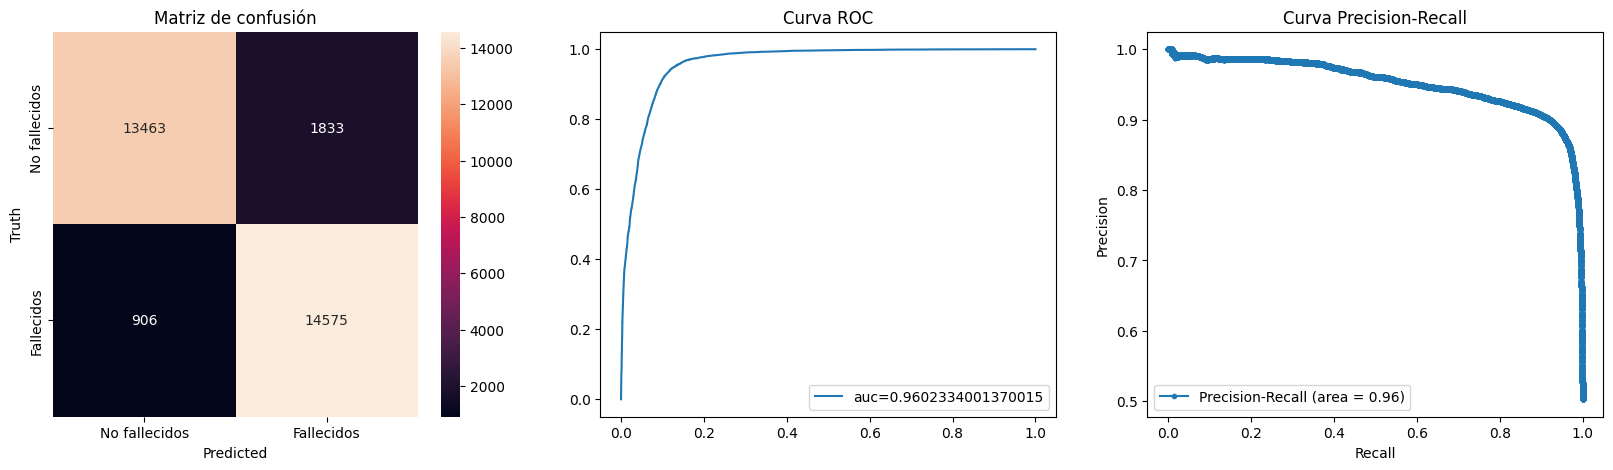

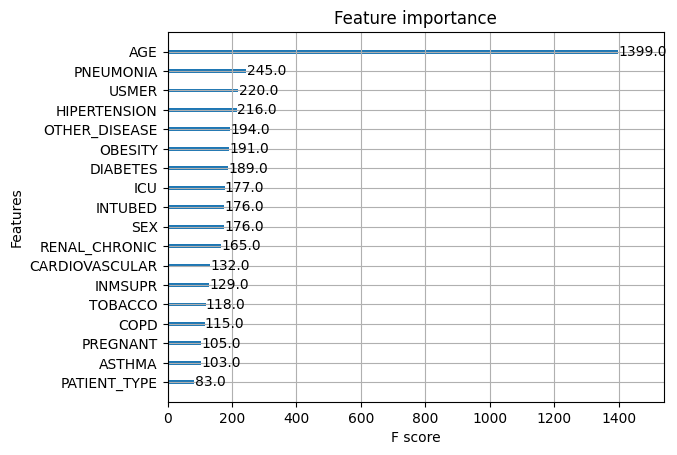

In [22]:
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1:", f1)


# grafiocamos la matriz de confusión

cm = confusion_matrix(y_test, y_pred)

print(f'Matriz de confusión: {cm}')
# Curva ROC

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Curva Precision-Recall

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# ploteo los 3 graficos en un mosaico

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(cm, annot=True, fmt='d', ax=ax[0])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Truth')
ax[0].set_title('Matriz de confusión')

# reemplazo 1 y 0 del heat map por fallecidos y no fallecidos para que se entienda mejor
ax[0].xaxis.set_ticklabels(['No fallecidos', 'Fallecidos'])
ax[0].yaxis.set_ticklabels(['No fallecidos', 'Fallecidos'])

ax[1].plot(fpr,tpr,label="auc="+str(auc))
ax[1].legend(loc=4)
ax[1].set_title('Curva ROC')

ax[2].plot(recall, precision, marker='.', label='Precision-Recall (area = %0.2f)' % auc)
ax[2].legend(loc="lower left")
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Curva Precision-Recall')

# guardo la imagen
plt.savefig('Metricas.png')

xgb.plot_importance(model)

# guardos importancia de las variables
plt.savefig('Importancia_variables.png')


plt.show()

# Analisis de falsos negativos

In [13]:
# buscamos los falsos negativos y armamos un df con ellos

falsos_negativos = np.where((y_test == 1) & (y_pred == 0))[0]

# Busco los indices de los falsos negativos
indices = X_test.iloc[falsos_negativos].index

# Armo un df con los falsos negativos

df_falsos_negativos = df_covid_downsampled.loc[indices]

df_falsos_negativos['falsos_negativos'] = y_pred[falsos_negativos]

features = ['USMER', 'SEX','INTUBED', 'PNEUMONIA', 'AGE','PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'PATIENT_TYPE']
df_falsos_negativos[features].head(10)


,USMER,SEX,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,PATIENT_TYPE
24225,2,0,0.0,0.0,41.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
22108,2,0,NaN,0.0,65.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1
43830,2,0,0.0,0.0,32.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
56641,1,0,NaN,1.0,31.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1
444764,1,0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
23166,2,0,NaN,0.0,67.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1
29127,1,0,NaN,0.0,45.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1
36313,2,0,NaN,0.0,56.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1
457083,2,1,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
431868,2,1,NaN,0.0,72.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1


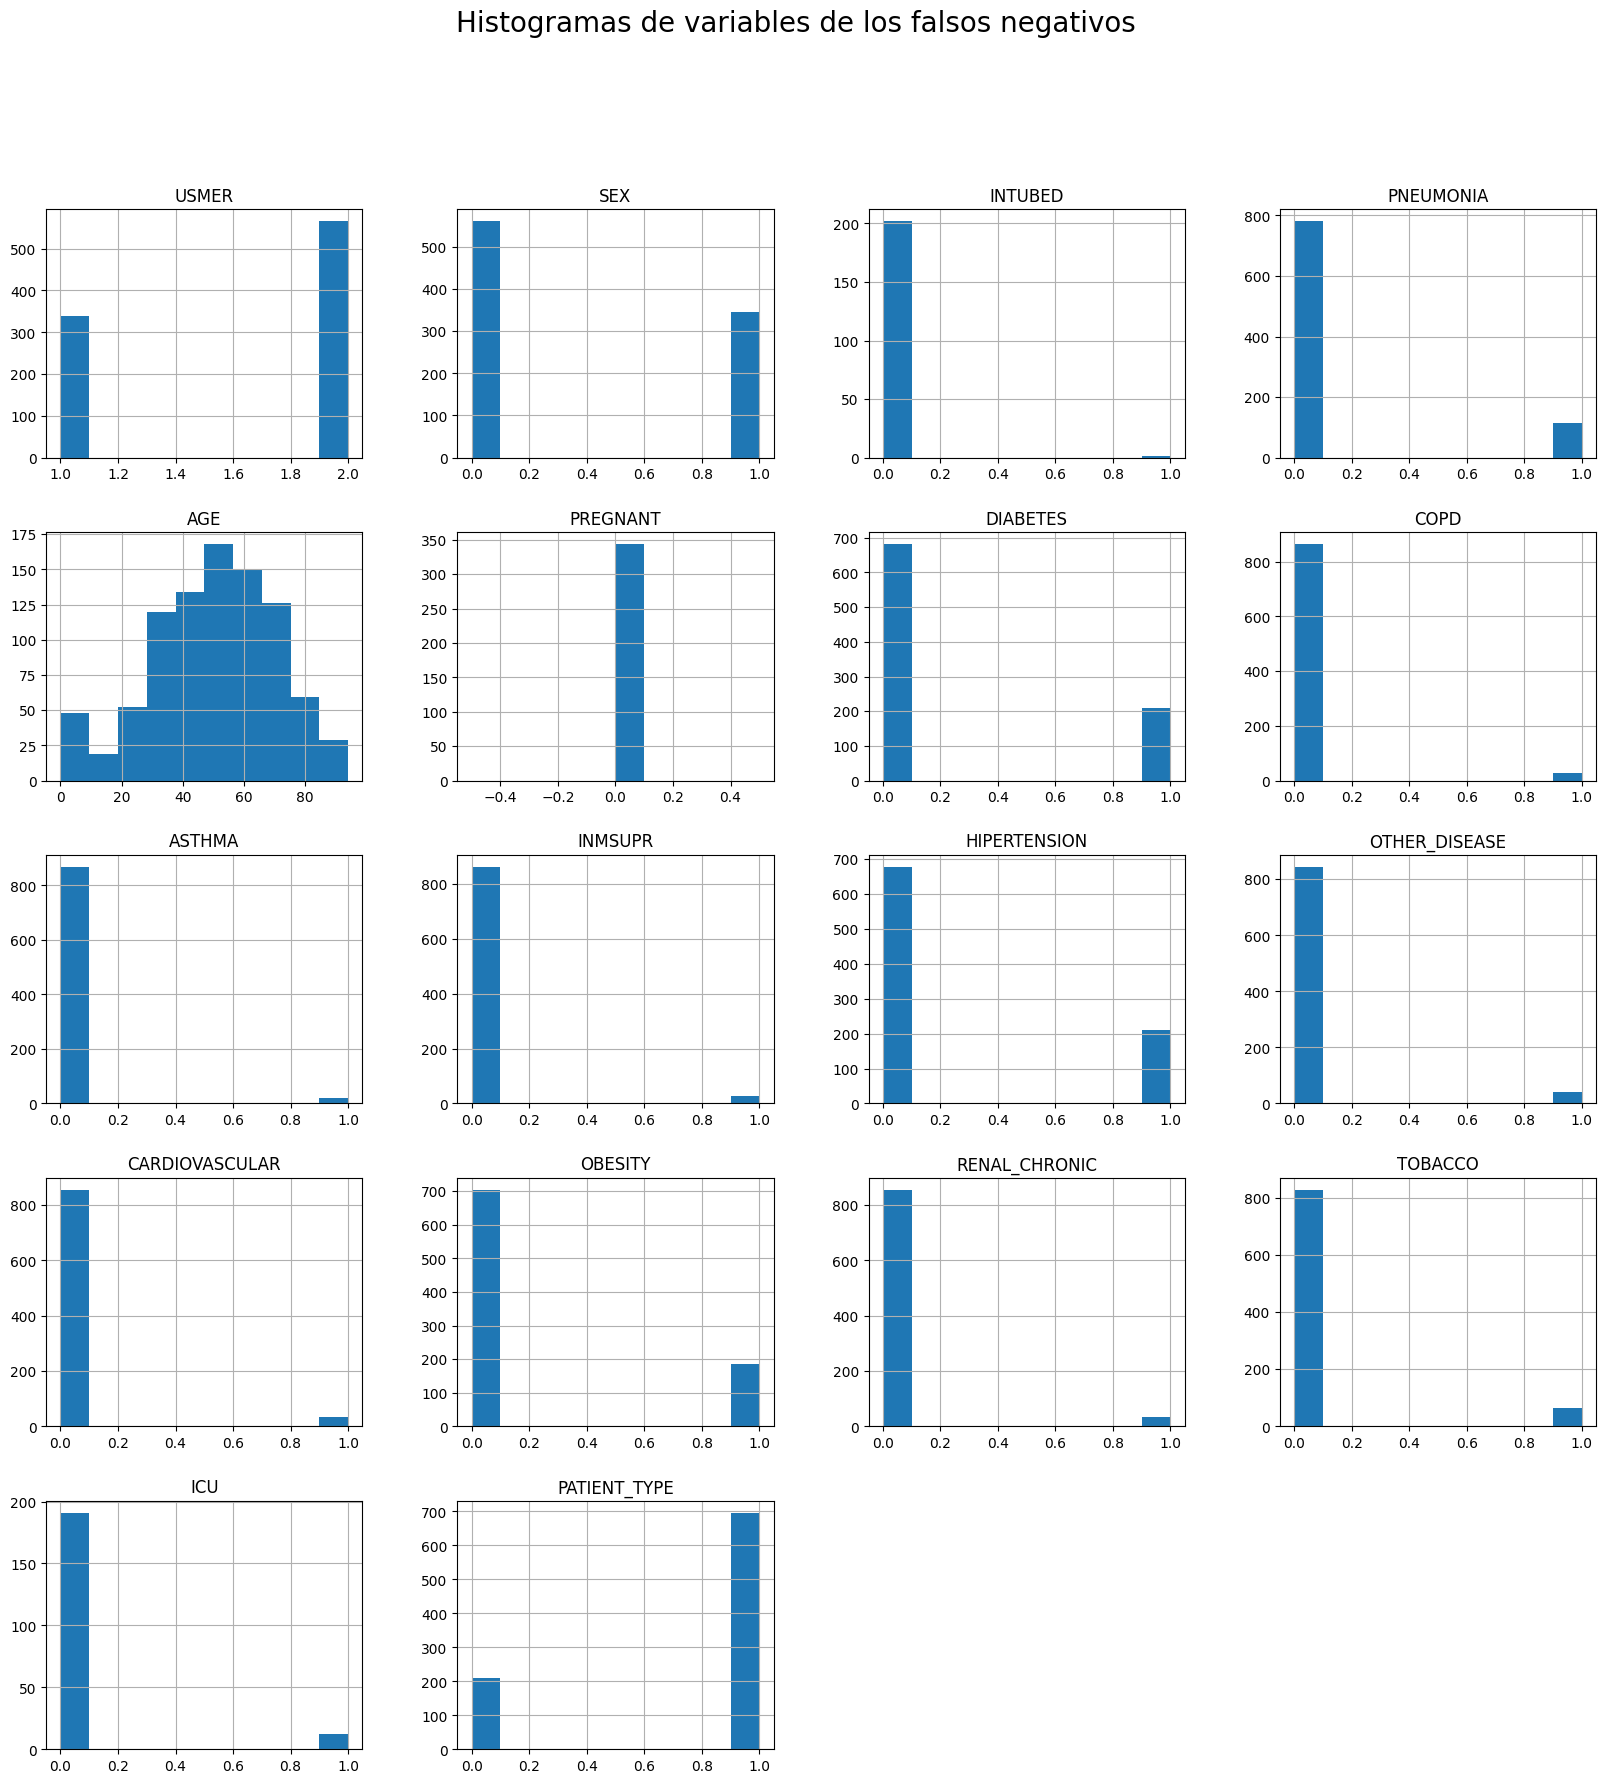

In [14]:

# graficamos las variables de df_falsos_negativos

df_falsos_negativos[features].hist(figsize=(20,20))
# agrego titulo

plt.suptitle('Histogramas de variables de los falsos negativos', fontsize=20)
plt.savefig('histogramas_falsos_negativos.png')
plt.show()


In [15]:
# buscamos los falsos positivos y armamos un df con ellos

falsos_positivos = np.where((y_test == 0) & (y_pred == 1))[0]

# Busco los indices de los falsos negativos
indices = X_test.iloc[falsos_positivos].index

# Armo un df con los falsos negativos

df_falsos_positivos = df_covid_downsampled.loc[indices]

df_falsos_positivos['falsos_negativos'] = y_pred[falsos_positivos]

features = ['USMER', 'SEX','INTUBED', 'PNEUMONIA', 'AGE','PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU', 'PATIENT_TYPE']
df_falsos_positivos[features].head(10)


,USMER,SEX,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,PATIENT_TYPE
136857,1,0,0.0,1.0,38.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
67591,1,1,0.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
283731,1,0,0.0,0.0,46.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
223771,1,1,NaN,NaN,83.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0
351201,2,0,0.0,1.0,70.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
580727,1,1,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
293888,1,1,0.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
300197,1,1,0.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
577942,2,1,NaN,1.0,63.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1
153346,2,0,0.0,1.0,79.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


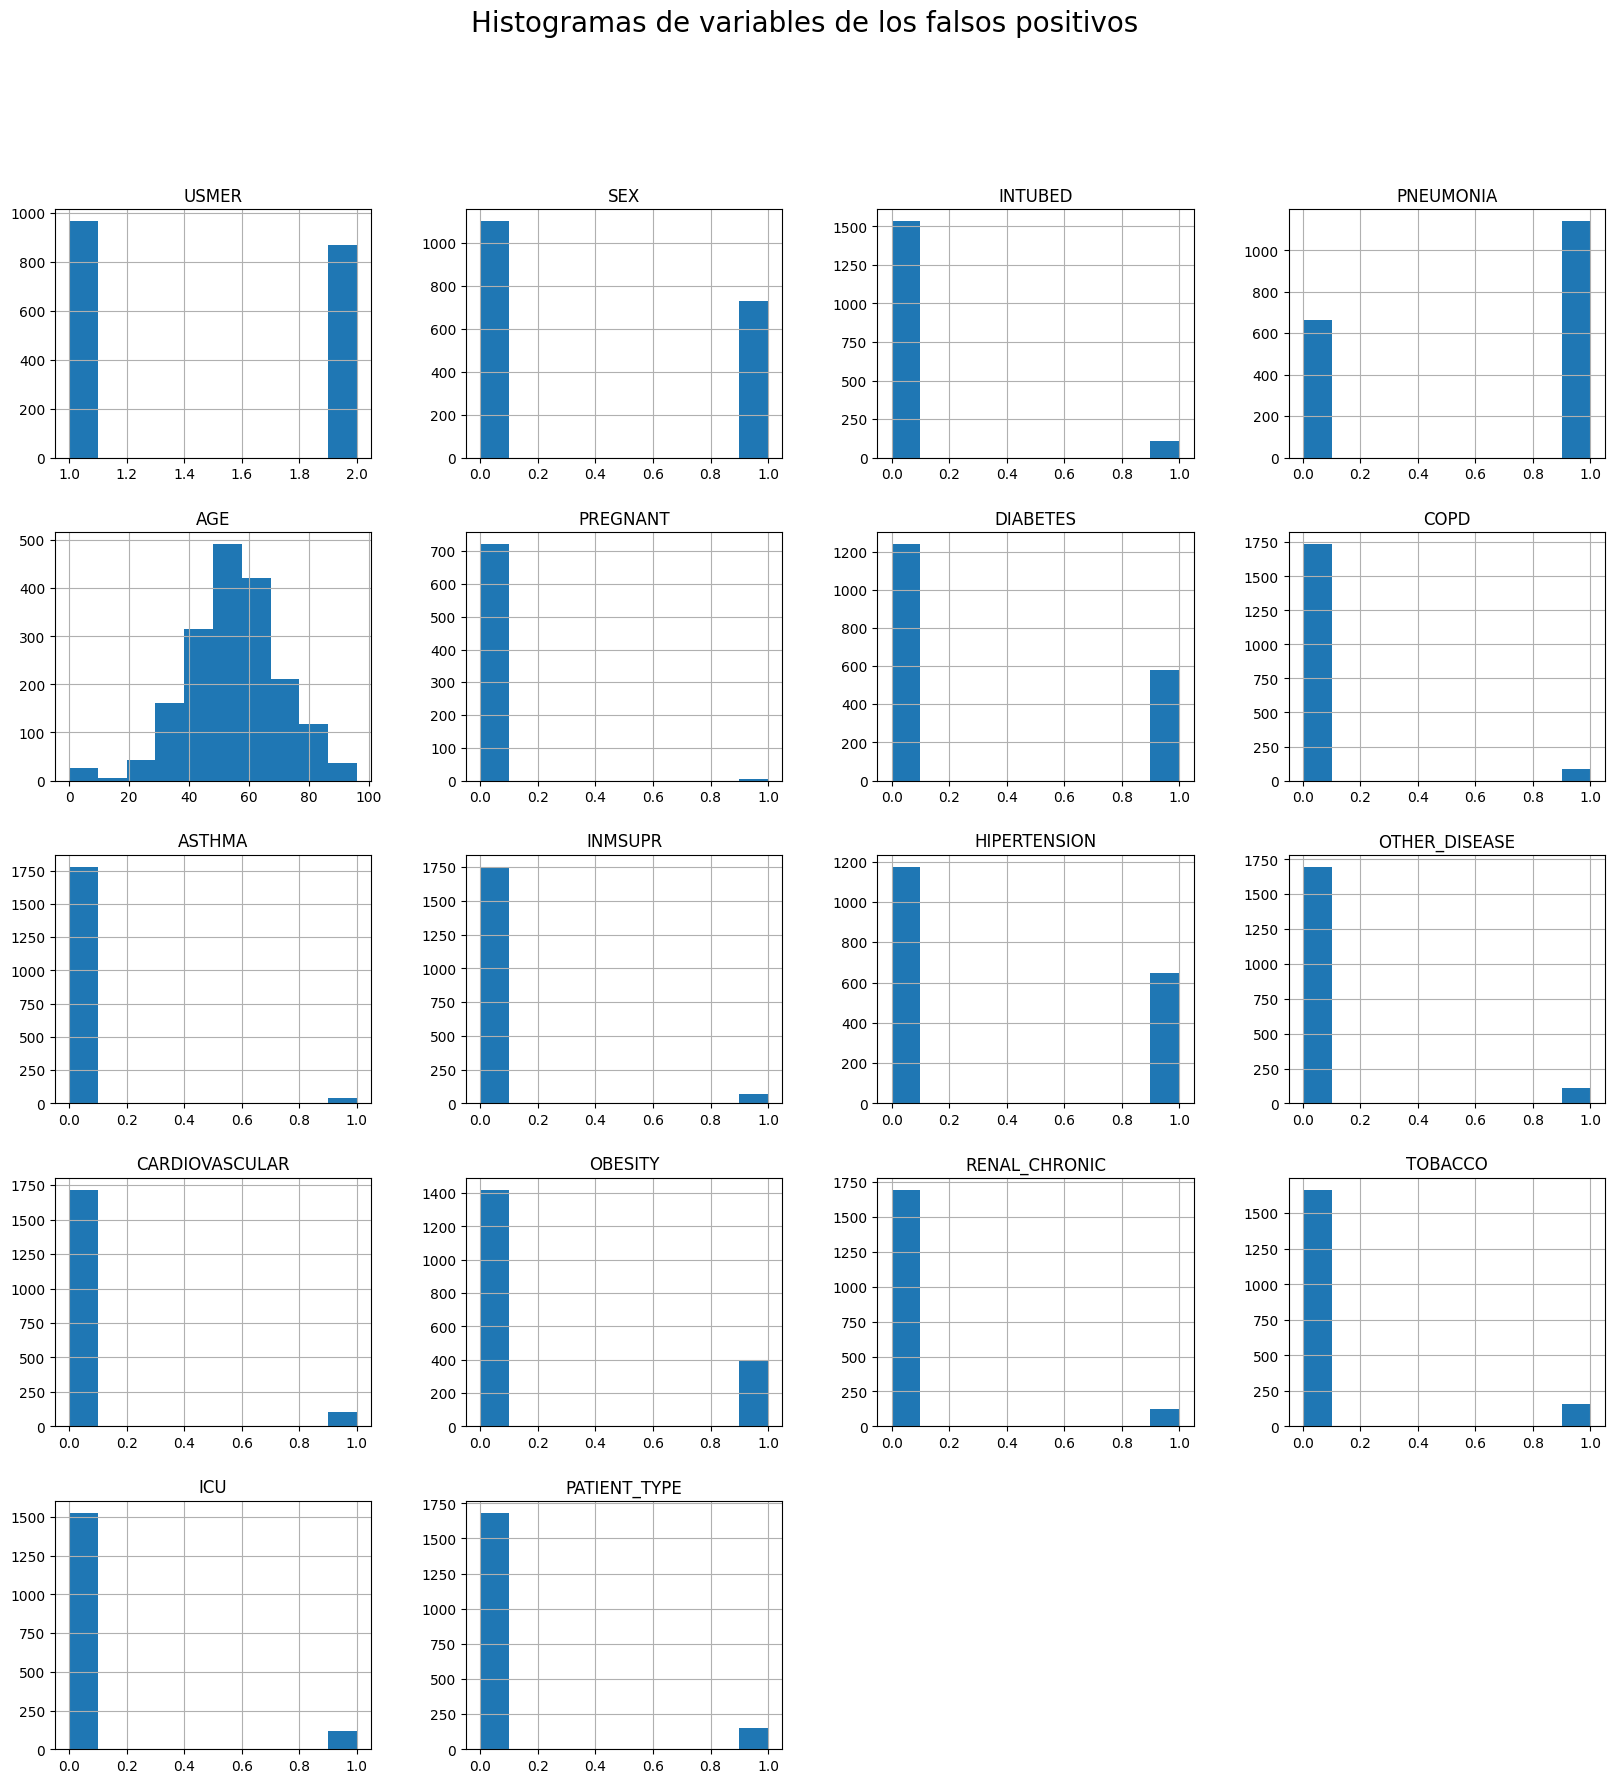

In [16]:
df_falsos_positivos[features].hist(figsize=(20,20))
# agrego titulo

plt.suptitle('Histogramas de variables de los falsos positivos', fontsize=20)
plt.savefig('histogramas_falsos_positivos.png')
plt.show()